In [151]:
import pennylane as qml
from pennylane import numpy as np
import networkx as nx

def SP(k):  # σ₊
    return 0.5 * (qml.PauliX(k) - 1j * qml.PauliY(k))

def SM(k):  # σ₋
    return 0.5 * (qml.PauliX(k) + 1j * qml.PauliY(k))

def number_op(k):  # n_x = 0.5 * (1 + Z)
    return 0.5 * (qml.Identity(k) + qml.PauliZ(k))
        
def build_hamiltonian(phi, N = 4, edges = [(1, 2), (2, 3), (2, 4), (1, 3), (3, 4)], Phi = (2, 3)):
    AB_phase = np.exp(1j * phi)

    # GRAPH FOR PATHS
    G = nx.Graph()
    G.add_edges_from(edges)
    nodes = sorted(set(i for e in edges for i in e))
    
    def jw_path(i, j):
        path = nx.shortest_path(G, i, j)
        return path[1:-1] if len(path) > 2 else []
    
    def sigma_anyonic(k, phi):
        if np.isclose(phi % (2*np.pi), np.pi):  # fermion case
            return number_op(k) * (-2)
        else:
            alpha = np.exp(1j * phi)
            return 0.5 * (alpha + 1) * qml.Identity(k) + 0.5 * (alpha - 1) * qml.PauliZ(k)
    
    def anyon_string(path, phi):
        if not path:
            return qml.Identity(wires=range(N))
        result = sigma_anyonic(path[0], phi)
        for k in path[1:]:
            result = result @ sigma_anyonic(k, phi)
        return result

    #triples = [(i, j, jw_path(i, j)) for i in nodes for j in nodes if i < j]
    triples = [(min(i,j), max(i,j), jw_path(i, j)) for (i, j) in edges]
    
    ops = []
    coeffs = []
    
    for i, j, path in triples:
        i0, j0 = i - 1, j - 1
        path0 = [k - 1 for k in path]
    
        # Phase on red link only
        t = AB_phase if (i, j) == Phi or (j, i) == Phi else 1.0
    
        sigma_string = anyon_string(path0, phi)
    
        # a†_i σ a_j
        term1 = SP(i0) @ sigma_string @ SM(j0)
        term2 = term1.adjoint()
    
        ops.extend([term1, term2])
        coeffs.extend([t, np.conj(t)])

    # ADD INTERACTION TERMS
    V = 1.0
    for i in range(N):
        for j in range(i + 1, N):
            ops.append(number_op(i) @ number_op(j))
            coeffs.append(V)
    
    H = qml.Hamiltonian(coeffs, ops)
    #Hmat = qml.matrix(H, wire_order=range(N))

    return H


In [152]:
from pennylane import math

H = build_hamiltonian(np.pi / 2)

potential_ops, potential_coeffs = [], []
kinetic_ops, kinetic_coeffs = [], []

for op, c in zip(H.ops, H.coeffs):
    mat = qml.matrix(op, wire_order=range(N))
    if np.allclose(mat, np.diag(np.diagonal(mat))):  # Diagonal term
        potential_ops.append(op)
        potential_coeffs.append(c)
    else:
        kinetic_ops.append(op)
        kinetic_coeffs.append(c)

In [153]:
# Verify kinetic term diagonal in QFT basis
H_kin = qml.Hamiltonian(kinetic_coeffs, kinetic_ops)
H_kin_matrix = qml.matrix(H_kin, wire_order=range(N))
U_qft = qml.matrix(qml.QFT(wires=range(N)), wire_order=range(N))

H_kin_qft_basis = U_qft @ H_kin_matrix @ U_qft.conj().T
off_diag = H_kin_qft_basis - np.diag(np.diagonal(H_kin_qft_basis))

print("Is H_kin diagonal in QFT basis?", np.allclose(off_diag, 0, atol=1e-8))


Is H_kin diagonal in QFT basis? False


In [154]:
H_kin_diag_basis = U_qft @ H_kin_matrix @ U_qft.conj().T
off_diagonal = H_kin_diag_basis - np.diag(np.diagonal(H_kin_diag_basis))
is_nearly_diagonal = np.allclose(off_diagonal, 0, atol=1e-8)
print("Diagonal in QFT basis?", is_nearly_diagonal)
print("Eigenvalues in QFT basis:", np.round(np.diagonal(H_kin_diag_basis), 5))

Diagonal in QFT basis? False
Eigenvalues in QFT basis: [ 2.     +0.j -0.05383-0.j -1.     +0.j -0.2706 +0.j -0.     +0.j
  0.9777 +0.j -0.     -0.j -0.65328-0.j  0.     +0.j -1.36039+0.j
 -1.     +0.j  0.2706 +0.j -0.     +0.j  0.43651-0.j -0.     -0.j
  0.65328+0.j]


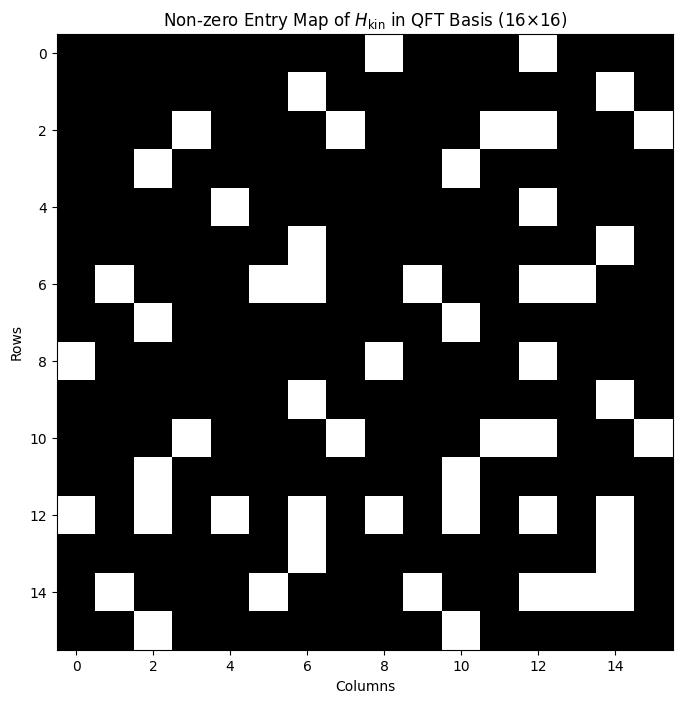

In [155]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))

# Create a binary mask of "effectively non-zero" entries
nonzero_mask = np.abs(H_kin_qft_basis) > 1e-8

plt.imshow(nonzero_mask, cmap='Greys', interpolation='none')
plt.title("Non-zero Entry Map of $H_{\\text{kin}}$ in QFT Basis (16×16)")
plt.xlabel("Columns")
plt.ylabel("Rows")
plt.grid(False)
plt.show()

In [156]:
def trotter_step(t_step):
    # Apply e^{-i V t}, assuming H_pot is diagonal (e.g., in Z basis)
    H_pot = qml.Hamiltonian(potential_coeffs, potential_ops)
    qml.ApproxTimeEvolution(H_pot, t_step, 1)

    # Apply QFT
    qml.QFT(wires=range(N))

    # Apply e^{-i K t} in momentum basis
    H_kin = qml.Hamiltonian(kinetic_coeffs, kinetic_ops)
    H_kin_matrix = qml.matrix(H_kin, wire_order=range(N))
    kinetic_diag = np.linalg.eigvalsh(H_kin_matrix)

    # Apply diagonal kinetic phase
    qml.DiagonalQubitUnitary(np.exp(-1j * kinetic_diag * t_step), wires=range(N))

    # Apply inverse QFT
    qml.adjoint(qml.QFT)(wires=range(N))

G_vals [0.078298267955058, 0.04309119218155792, 0.05180553489925362, 0.05349006746395261, 0.053877017909876625, 0.05394719292155282, 0.0539716451550633]


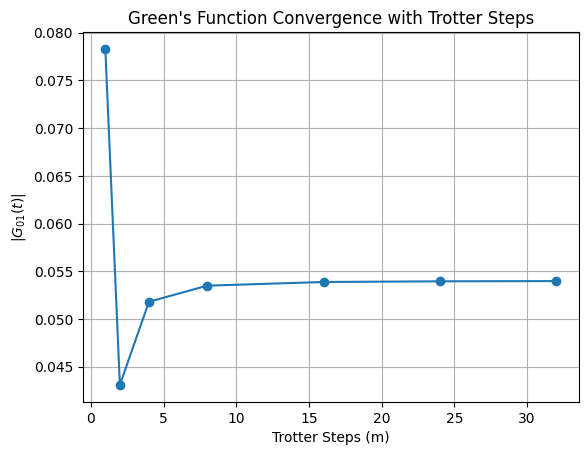

In [157]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

N = 4  # Number of sites
i, j = 0, 1  # Mode indices for Green's function G_{ij}(t)

dev = qml.device("default.qubit", wires=N)

@qml.qnode(dev)
def evolved_state(t, m):
    """Prepare 2-particle basis state and evolve under Trotterized Hamiltonian."""
    index = (1 << i) | (1 << j)  # Occupy modes i and j
    bits = np.array([int(b) for b in format(index, f'0{N}b')])
    qml.BasisState(bits, wires=range(N))

    dt = t / m
    for _ in range(m):
        trotter_step(dt)
    return qml.state()

def create_excited_state(j):
    """Return state vector corresponding to single-particle excitation at site j."""
    state = np.zeros(2**N, dtype=complex)
    state[1 << j] = 1.0
    return state

# Evaluate Green's function G_{ij}(t) for various Trotter steps
t = 1.0
m_vals = [1, 2, 4, 8, 16, 32]
G_vals = []

for m in m_vals:
    ψ_t = evolved_state(t, m)
    c_i = qml.matrix(SM(i), wire_order=range(N))  # Apply lowering operator c_i
    ψ_j = create_excited_state(j)
    G_ij = np.vdot(ψ_j, c_i @ ψ_t)  # ⟨ψ_j | c_i | ψ(t)⟩
    G_vals.append(np.abs(G_ij))

print("G_vals", G_vals)

# Plot convergence behavior
plt.plot(m_vals, G_vals, marker='o')
plt.xlabel("Trotter Steps (m)")
plt.ylabel(r"$|G_{%d%d}(t)|$" % (i, j))
plt.title("Green's Function Convergence with Trotter Steps")
plt.grid(True)
plt.show()


In [158]:
from scipy.linalg import expm

H_anyon = build_hamiltonian(np.pi / 2)

# Initial 2-particle state |ψ_{ij}⟩ = c_i† c_j† |vac⟩
ψ_init = np.zeros(2**N, dtype=complex)
index = (1 << i) | (1 << j)
ψ_init[index] = 1.0

# Convert H_anyon to full matrix
H_matrix = qml.matrix(H_anyon, wire_order=range(N))

# Time evolution
U = expm(-1j * H_matrix * t)
ψ_t = U @ ψ_init

# Fermionic annihilation operator c_i as full matrix
c_i_mat = qml.matrix(SM(i), wire_order=range(N))

# Compute Green's function
G_exact = np.vdot(psi_j, c_i_mat @ ψ_t)
print("Exact |G_ij(t)| =", np.abs(G_exact))


Exact |G_ij(t)| = 0.32292684643419345


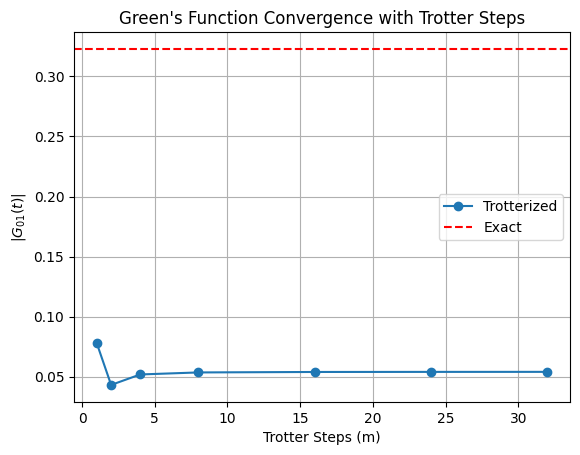

In [159]:
from scipy.linalg import expm

# Compute exact time evolution using full Hamiltonian matrix
H_anyon = build_hamiltonian(np.pi / 2)  # or whatever phi you're using
H_matrix = qml.matrix(H_anyon, wire_order=range(N))

psi_init = np.zeros(2**N, dtype=complex)
psi_init[(1 << i) | (1 << j)] = 1.0

U_exact = expm(-1j * H_matrix * t)
psi_t_exact = U_exact @ psi_init

c_i_exact = qml.matrix(SM(i), wire_order=range(N))
psi_j = create_excited_state(j)

G_exact = np.vdot(psi_j, c_i_exact @ psi_t_exact)
G_abs_exact = np.abs(G_exact)

# Plot convergence behavior
plt.plot(m_vals, G_vals, marker='o', label="Trotterized")
plt.axhline(y=G_abs_exact, color='red', linestyle='--', label="Exact")

plt.xlabel("Trotter Steps (m)")
plt.ylabel(r"$|G_{%d%d}(t)|$" % (i, j))
plt.title("Green's Function Convergence with Trotter Steps")
plt.grid(True)
plt.legend()
plt.show()

In [163]:
Hmat = qml.matrix(H_anyon, wire_order=range(N))
print("H_anyon shape:", Hmat.shape)
print("H_anyon diagonal?", np.allclose(Hmat, np.diag(np.diagonal(Hmat))))
print("Nonzero entries in H:", np.count_nonzero(np.abs(Hmat) > 1e-8))

H_anyon shape: (16, 16)
H_anyon diagonal? False
Nonzero entries in H: 51


In [168]:
def occupation_prob(psi, site):
    N = int(np.log2(len(psi)))
    I = np.eye(2)
    Z = np.array([[1, 0], [0, -1]])
    ops = [I] * N
    ops[site] = Z
    Z_k = ops[0]
    for op in ops[1:]:
        Z_k = np.kron(Z_k, op)
    n_k = 0.5 * (np.eye(2**N) + Z_k)
    return np.real(psi.conj().T @ n_k @ psi)


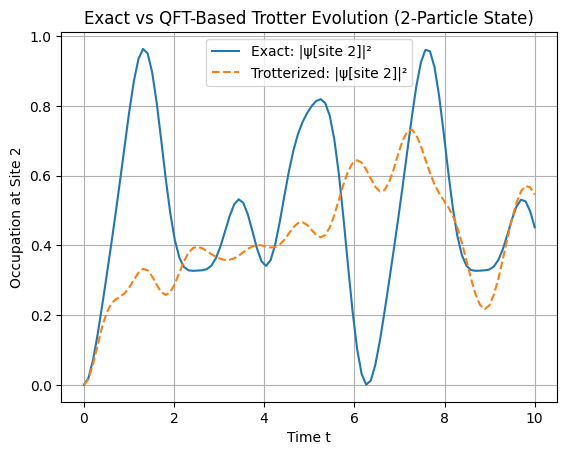

In [169]:
psi_0 = np.zeros(2**N, dtype=complex)
index = (1 << i) | (1 << j)
psi_0[index] = 1.0

t_vals = np.linspace(0, 10, 100)
m = 32  # number of Trotter steps

exact_vals = []
qft_vals = []

H_anyon = build_hamiltonian(np.pi / 2)

from scipy.linalg import expm

def exact_evolution(H, psi, t):
    Hmat = qml.matrix(H, wire_order=range(N))
    Hmat = np.array(Hmat)  # ensure it's not symbolic/autograd
    U = expm(-1j * Hmat * t)
    return U @ psi

for t in t_vals:
    ψ_exact = exact_evolution(H_anyon, psi_0, t)
    ψ_qft = evolved_state(t, m)

    prob_exact = occupation_prob(ψ_exact, site=2)
    prob_qft = occupation_prob(ψ_qft, site=2)

    exact_vals.append(prob_exact)
    qft_vals.append(prob_qft)

plt.plot(t_vals, exact_vals, label="Exact: |ψ[site 2]|²")
plt.plot(t_vals, qft_vals, "--", label="Trotterized: |ψ[site 2]|²")
plt.xlabel("Time t")
plt.ylabel("Occupation at Site 2")
plt.title("Exact vs QFT-Based Trotter Evolution (2-Particle State)")
plt.grid(True)
plt.legend()
plt.show()
